# Linear Regression

The workhorse of empirical research in the social sciences

In [4]:
import matplotlib as mpl
import pandas as pd
import pyrsm as rsm

# increase plot resolution
mpl.rcParams["figure.dpi"] = 150


In [5]:
rsm.__version__

'0.5.12.11'

### Example 1: Catalog sales

We have access to data from a company selling men's and women's apparel through mail-order catalogs (dataset `catalog`). The company maintains a database on past and current customers' value and characteristics. Value is determined as the total \$ sales to the customer in the last year.

The catalog company is interested in redesigning their Customer Relationship Management (CRM) strategy. We will proceed in two steps:

1. Estimate a regression model using last year's sales total. Response variable: sales total for each of the 200 households; Explanatory variables: household income (measured in thousands of dollars), size of household, and age of the household head.
2. Interpret each of the estimated coefficients. Also provide a statistical evaluation of the model as a whole.

In [6]:
rsm.load_data(pkg="model", name="catalog", dct=globals())

In [7]:
rsm.describe(catalog)

## Catalog sales

### Description

Data from a company selling men's and women's apparel through mail-order catalogs. The company maintains a database on past and current customers' value and characteristics. Value is determine as the total $ sales to the customer in the last year. The data are a random sample of 200 customers from the company's database.

### Variables

A data frame with 200 observations on 4 variables

- id = Customer id
- Sales =	Total sales (in $) to a household in the past year
- Income = Household income ($1000) 
- HH.size = Size of the household (# of people) 
- Age = Age of the head of the household

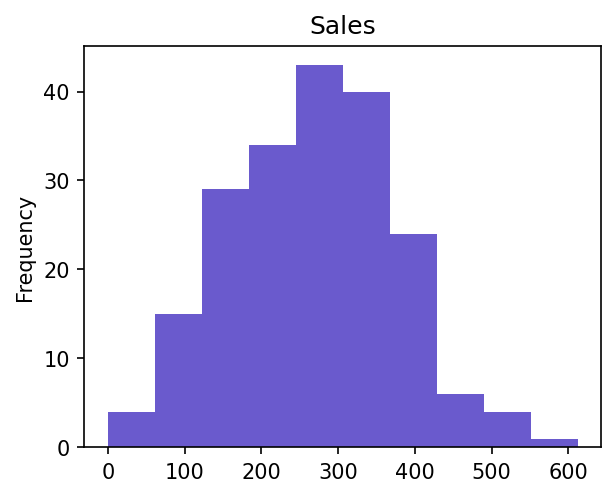

In [8]:
rsm.distr_plot(catalog[["Sales"]])

In [ ]:
evars = ["Income", "HH_size", "Age"]
rvar = "Sales"

In [ ]:
fitted = rsm.regress(catalog, rvar=rvar, evars=evars, ssq=True)

In [ ]:
fitted = rsm.regress(catalog, form="Sales ~ Income + HH_size + Age")


In [ ]:
params = dict(zip(["dfn", "dfd", "lb", "ub", "decimals"], [3, 196, 0, 0.975, 3]))
prob_calc_f = rsm.prob_calc("F", params)
prob_calc_f.calculate()
prob_calc_f.plot()

In [ ]:
params = dict(zip(["df", "lb", "ub", "decimals"], [196, 0.025, 0.975, 3]))

prob_calc_t = rsm.prob_calc("t", params)
prob_calc_t.calculate()
prob_calc_t.plot()

### Example 2: Ideal data for regression

The data `ideal` contains simulated data that is very useful to demonstrate what data for, and residuals from, a regression should ideally look like. The data has 1,000 observations on 4 variables. `y` is the response variable and `x1`, `x2`, and `x3` are explanatory variables. The plots shown below can be used as a bench mark for regressions on real world data

In [ ]:
rsm.load_data(pkg="model", name="ideal", dct=globals())

In [ ]:
rsm.describe(ideal)

In [ ]:
evars = ["x1", "x2", "x3"]
rvar = "y"

In [ ]:
fitted = rsm.regress(ideal, evars=evars, rvar=rvar)

In [ ]:
rsm.distr_plot(ideal)

In [ ]:
cr = rsm.correlation(ideal[["y", "x1", "x2", "x3"]])
cr.plot(nobs=-1, figsize=(10, 10))

In [ ]:
# not working yet
rsm.scatter_plot(fitted)

In [ ]:
# qqplot and formula interface? 
# the formula interface is important because it makes undummify unnecessary
rsm.reg_dashboard(fitted=fitted, nobs=-1)

In [ ]:
# not working yet
rsm.residual_vs_explanatory_plot(fitted)

In [ ]:
# not working yet
rsm.scatter_plot(fitted)

### Example 3: Linear or log-log regression?

Both linear and log-log regressions are commonly applied to business data. In this example we will look for evidence in the data and residuals that may suggest which model specification is  appropriate for the available data.

In [ ]:
rsm.load_data(pkg="data", name="diamonds", dct=globals())

In [ ]:
rsm.describe(diamonds)

In [ ]:
rsm.distr_plot(diamonds, cols=["price", "carat", "clarity"])

In [ ]:
diamonds.columns

In [ ]:
cr = rsm.correlation(diamonds[["price", "carat", "clarity"]])
cr.plot(nobs=-1, figsize=(10, 10))

In [ ]:
fitted = rsm.regress(diamonds, rvar="price", evars=["carat", "clarity"])

In [ ]:
rsm.scatter_plot(fitted)

In [ ]:
rsm.reg_dashboard(fitted) # not sure why this is different from the one at https://radiant-rstats.github.io/docs/model/regress.html

In [ ]:
rsm.residual_vs_explanatory_plot(fitted)

In [ ]:
from math import log

In [ ]:
# prefer lower case for functions and class for consistency with Radiant
tf = rsm.Transform(diamonds, ["price", "carat"], "ln")
diamonds_ln = tf.transform()

In [ ]:
diamonds_ln

In [ ]:
rsm.scatter(diamonds_ln, "carat_ln", "price_ln")

In [ ]:
rsm.distr_plot(diamonds_ln, cols=["price_ln", "carat_ln", "clarity"])

In [ ]:
cr = rsm.correlation(diamonds_ln[["price_ln", "carat_ln", "clarity"]])
cr.plot(nobs=-1, figsize=(10, 10))

In [ ]:
fitted = rsm.regress(diamonds_ln, rvar="price_ln", evars=["carat_ln", "clarity"])

In [ ]:
rsm.scatter_plot(fitted)

In [ ]:
rsm.reg_dashboard(fitted)

In [ ]:
rsm.residual_vs_explanatory_plot(fitted)